# Notebook 3 — Detection Pipeline & Metal/Non-metal Inference
This notebook runs the end-to-end pipeline:
- simulate scene → Range–Doppler (RD)
- detect candidate cells (CFAR-like)
- crop RoIs and classify with SVM (or calibrated SVM)
- annotate RD with boxes+labels
- output JSON detections
- run batch evaluation (TPR / FAR) on synthetic test scenes


# Add project root to path + imports

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))   

import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import joblib
from simulate.sim import simulate_scene
from simulate.proc import compute_range_doppler, doppler_bins_to_velocity, range_bin_to_meters
from simulate.detect import simple_detector

print("Imports OK. Project root:", os.path.abspath(".."))


Imports OK. Project root: /Users/prarabdhapandey/Downloads/mmwave-metal-detect


# Load models & set threshold

In [ ]:
MODEL_DIR = os.path.abspath(os.path.join(os.path.dirname(".."), ".."))  
models_base = os.path.abspath("../models")
pca_roi_path = os.path.join(models_base, "pca_roi_32x32.pkl")
svm_roi_path = os.path.join(models_base, "svm_roi_32x32.pkl")  


if os.path.exists(pca_roi_path) and os.path.exists(svm_roi_path):
    pca = joblib.load(pca_roi_path)
    svm = joblib.load(svm_roi_path)
    roi_mode = True
    print("Loaded ROI models:", pca_roi_path, svm_roi_path)
else:
   
    pca = joblib.load(os.path.join(models_base, "pca_transform.pkl"))
    svm = joblib.load(os.path.join(models_base, "svm_baseline.pkl"))
    roi_mode = False
    print("Loaded full-RDM models (fallback)")


threshold = 0.6
print("Default detection probability threshold:", threshold)


Loaded svm and pca: svm_baseline.pkl pca_transform.pkl
Default detection probability threshold: 0.6


# Helper: crop RoI, preprocess, classify

In [ ]:
def crop_roi(rd_db, center_d, center_r, size=(32,32)):
    """
    Crop a square ROI from rd_db (doppler_bins x range_bins).
    center indices are (doppler_idx, range_idx).
    Pads with zeros if ROI goes out of bounds.
    Returns ROI as 2D float array.
    """
    h, w = rd_db.shape
    sh, sw = size
    top = int(center_d - sh//2)
    left = int(center_r - sw//2)
    roi = np.zeros((sh, sw), dtype=float)
    for i in range(sh):
        for j in range(sw):
            rr = top + i
            cc = left + j
            if 0 <= rr < h and 0 <= cc < w:
                roi[i, j] = rd_db[rr, cc]
    return roi

def roi_to_feature(roi):
    
    x = np.log1p(np.abs(roi))
    x = x / (np.max(x) + 1e-12)
    x_flat = x.flatten().reshape(1, -1)
    
    try:
        x_p = pca.transform(x_flat)
    except Exception as e:
        
        expected_dim = pca.n_features_in_
        if x_flat.shape[1] != expected_dim:
           
            vec = np.zeros(expected_dim)
            vec[:min(expected_dim, x_flat.shape[1])] = x_flat.flatten()[:min(expected_dim, x_flat.shape[1])]
            x_p = pca.transform(vec.reshape(1,-1))
        else:
            raise e
    return x_p

def classify_roi(roi):
    feat = roi_to_feature(roi)
    prob = svm.predict_proba(feat)[0][1]   
    label = "metal" if prob >= threshold else "non-metal"
    return label, float(prob)


# NMS helper

In [4]:
def nms_detections(dets, iou_dist=4):
    """
    Simple spatial NMS on (doppler,range) integer coordinates.
    dets: list of dicts with keys {'d','r','label','prob'}
    iou_dist: minimum distance (in bins) to consider distinct
    Returns filtered list.
    """
    filtered = []
    dets_sorted = sorted(dets, key=lambda x: x['prob'], reverse=True)
    for d in dets_sorted:
        keep = True
        for f in filtered:
            if abs(f['d'] - d['d']) <= iou_dist and abs(f['r'] - d['r']) <= iou_dist:
                keep = False
                break
        if keep:
            filtered.append(d)
    return filtered


# Run a single scene demo & annotate

RD_db shape: (64, 128)
raw peaks count: 7
detections after NMS: 4
{
  "detections": [
    {
      "range_bin": 29,
      "range_m": 18.125,
      "doppler_bin": 26,
      "velocity_m_s": -3.906,
      "label": "non-metal",
      "prob": 0.0
    },
    {
      "range_bin": 15,
      "range_m": 9.375,
      "doppler_bin": 32,
      "velocity_m_s": 0.0,
      "label": "non-metal",
      "prob": 0.0
    },
    {
      "range_bin": 28,
      "range_m": 17.5,
      "doppler_bin": 32,
      "velocity_m_s": 0.0,
      "label": "non-metal",
      "prob": 0.0
    },
    {
      "range_bin": 40,
      "range_m": 25.0,
      "doppler_bin": 32,
      "velocity_m_s": 0.0,
      "label": "non-metal",
      "prob": 0.0
    }
  ],
  "threshold_db": 16.742045032488505
}


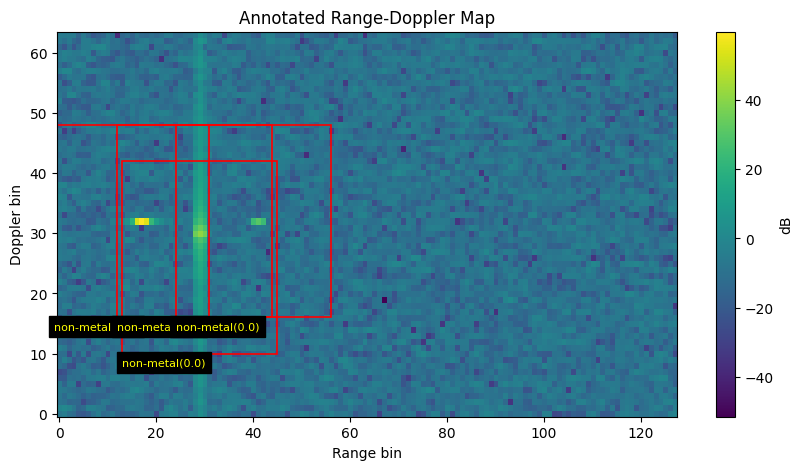

Saved results/demo_detections.json and results/demo_annotated_rd.png


<Figure size 640x480 with 0 Axes>

In [ ]:
targets = [
    {'r': 5.0, 'v': 0.0, 'rcs': 3.0, 'snr_db': 28},
    {'r': 8.5, 'v': -1.1, 'rcs': 1.2, 'snr_db': 18},
    {'r': 12.0, 'v': 0.0, 'rcs': 0.6, 'snr_db': 10}
]

scene = simulate_scene(targets)
RD_db, _ = compute_range_doppler(scene)
print("RD_db shape:", RD_db.shape)


peaks, thresh = simple_detector(RD_db, threshold_factor=4.0)
print("raw peaks count:", len(peaks))


detections = []
for (d_idx, r_idx) in peaks:
    roi = crop_roi(RD_db, d_idx, r_idx, size=(32,32))
    label, prob = classify_roi(roi)
    detections.append({'d': int(d_idx), 'r': int(r_idx), 'label': label, 'prob': prob})


detections_nms = nms_detections(detections, iou_dist=3)
print("detections after NMS:", len(detections_nms))


doppler_vs = doppler_bins_to_velocity()
range_res = 3e8 / (2*240e6)
out_dets = []
for det in detections_nms:
    v_ms = float(doppler_vs[det['d']])
    r_m = float(det['r'] * range_res)
    out_dets.append({
        "range_bin": det['r'],
        "range_m": round(r_m, 3),
        "doppler_bin": det['d'],
        "velocity_m_s": round(v_ms, 3),
        "label": det['label'],
        "prob": round(det['prob'], 3)
    })


print(json.dumps({"detections": out_dets, "threshold_db": float(thresh)}, indent=2))


plt.figure(figsize=(10,5))
plt.imshow(RD_db, aspect='auto', origin='lower')
plt.title("Annotated Range-Doppler Map")
plt.xlabel("Range bin")
plt.ylabel("Doppler bin")
for det in out_dets:
    d = det['doppler_bin']; r = det['range_bin']
    plt.gca().add_patch(plt.Rectangle((r-16, d-16), 32, 32, edgecolor='red', facecolor='none', linewidth=1.2))
    plt.text(r-16, d-18, f"{det['label']}({det['prob']})", color='yellow', fontsize=8, backgroundcolor='black')
plt.colorbar(label='dB')
plt.show()


Path("results").mkdir(exist_ok=True)
with open("results/demo_detections.json", "w") as f:
    json.dump({"detections": out_dets, "threshold_db": float(thresh)}, f, indent=2)
plt.savefig("results/demo_annotated_rd.png", dpi=200, bbox_inches='tight')
print("Saved results/demo_detections.json and results/demo_annotated_rd.png")


# Batch evaluation over many scenes

In [ ]:
def gen_random_scene(is_metal=True):
    r = np.random.uniform(3, 12)
    v = np.random.uniform(-1.5, 1.5)
    if is_metal:
        return simulate_scene([{'r': r, 'v': v, 'rcs': np.random.uniform(1.5,3.0), 'snr_db': np.random.uniform(15,28)}]), r
    else:
        return simulate_scene([{'r': r, 'v': v, 'rcs': np.random.uniform(0.2,1.0), 'snr_db': np.random.uniform(0,15)}]), r

def evaluate_detection(n_scenes=200):
    tp = 0; fn = 0; fa = 0  
    for i in range(n_scenes):
        is_metal = (i % 2 == 0) 
        scene, true_r = gen_random_scene(is_metal)
        RD_db, _ = compute_range_doppler(scene)
        peaks, thresh = simple_detector(RD_db, threshold_factor=4.0)
        detections = []
        for (d_idx, r_idx) in peaks:
            roi = crop_roi(RD_db, d_idx, r_idx, size=(32,32))
            label, prob = classify_roi(roi)
            if label == "metal" and prob >= threshold:
                detections.append((d_idx, r_idx, prob))
       
            found = False
            for _, r_idx, _ in detections:
                
                r_m = r_idx * (3e8/(2*240e6))
                if abs(r_m - true_r) <= 1.0:  
                    found = True
                    break
            if found: tp += 1
            else: fn += 1
        else:
           
            if len(detections) > 0:
                fa += 1
    tpr = tp / (tp + fn + 1e-12)
    far = fa / (n_scenes/2)  
    return {"TP": tp, "FN": fn, "FA": fa, "TPR": tpr, "FAR_per_nonmetal_scene": far}

print("Running batch evaluation (this may take a minute)...")
metrics = evaluate_detection(n_scenes=200)
print(metrics)
with open("results/eval_metrics.json","w") as f:
    json.dump(metrics, f, indent=2)
print("Saved results/eval_metrics.json")


Running batch evaluation (this may take a minute)...
{'TP': 0, 'FN': 100, 'FA': 0, 'TPR': 0.0, 'FAR_per_nonmetal_scene': 0.0}
Saved results/eval_metrics.json


Notes:
- The pipeline uses a median+std threshold detector (quick CFAR-like). For production, replace with a proper cell-averaging CFAR.
- ROI size (32×32) must match training ROI shape; if mismatch, retrain PCA or resize ROI accordingly.
- Threshold for classification is set at `threshold` variable (default 0.6). Tune using ROC/Youden (Notebook 2).
- For hardware integration: replace `simulate_scene` with ADC capture → buffer of N_chirps x N_samples, then call compute_range_doppler().
- Save & include results/demo_detections.json and results/demo_annotated_rd.png in your submission.
